In [1]:
from scipy.io import wavfile
from scipy import signal as ss
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from yin_detection import *
%load_ext line_profiler

# The YIN algorithm

### Step 1: Autocorrelation
$$r_t(\tau) = \sum_{j=t+1}^{t+W}x_j \cdot x_{j+\tau}$$

Asumiendo que la señal $x(t)$ sea periodica, podriamos encontrar la fecuencia fundamental haciendo una busqueda exaustiva, en un rango de lags, de los maximos en la fucnion de autocorrelacion. Pero si el limite inferior del rango de busqueda se encuentra muy cercano a 0, se pueden inducir errores, como tambien si el limite superior es suficientemente alto puede llevar a seleccionar picos de orden superior.

### Step 2: Diference function

Nuevamente asumiendo a la señal como periódica tenemos que:
 
$$ x_t - x_{t+T} = 0 $$

Igualdad que se mantiene si elevamos al cuadrado y sumamos sucesivos intervalos de tiempo

$$ \sum_{j=t+1}^{t+W} (x_j - x_{j+T})^2 = 0 $$

Llamando $d_t(\tau)$ a la suma y operando se llega a que 

$$ d_t(\tau) = \sum_{j=1}^{W} (x_j - x_{j+\tau})^2 = \sum_{j=1}^{W} (x_j^2 + x_{j+\tau}^2 - 2 \cdot x_j \cdot x_{j+\tau}) $$

Obteniendo 

$$ d_t(\tau) = r_t(0) + r_{t+\tau}(0) - 2 \cdot r_t(\tau) $$

De los cuales los primeros dos terminos hacen referencia a la enrgia de la señal, y asumiendo a los mismos constantes, la funcion varia de forma opuesta a la autocorrelacion de la señal, dando a entender que seria lo mismo buscar un maximo de una o un minimo de la otra, pero el segundo termino tambien depende del lag al cual evaluemos la funcion diferencia y mejora el rendimiento respecto de la fucnion de autocorrelacion debido a los cambios de amplitud de la señal. Por ejemplo, un aumento de la amplitud de la señal aumenta la funcion de autocorrelacion con los lags en lugar de ser constante, lo que puede porvocar elegir un pico superior, obteniendo una frecuencia inferior por error. 

### Step 3: Cumulative Mean Normalized Diference

A pesar de la mejora que implica el uso de la funcion de diferenicas, la misma es 0 para lag 0, y por imperfecciones en la periodicidad de la señal puede no ser 0 en los lags periodicos, por lo cual puede inducir a errores en la decisión. Para ello se introduce la funcion CMNDF, en la cual se compara la fucnion de diferencias en un lag con el promedio de las diferencias a lags inferiores.
$$ d_t^{\, '}(\tau) = 1,\quad \tau = 0$$
$$ d_t^{\, '}(\tau) = \frac{d_t(\tau)\cdot \tau}{\sum_{j=1}^{\tau}d_t(\tau)}, \quad \tau \neq 0$$
Esto genera que la funcion comience en 1, y se acerce a 0 una vez que la diferencia es menor que el promedio de las anteriores, lo que se porvoca cerca de los lags que indican periodicidad de la señal

### Step 4: Threshold decision line

Finalmente para la eleccion del lag correspondiente a la frecuencia fundamental, es posible que lag correspondiente a armonicos tengan minimos menores que el principal, induciendo errores. Para evitar dichos errores por \"armonicos\" lo que se realiza es establecer un threshold de decición y buscar el primer minimo local de la CMNDF 

# Optimizaciones realizadas

Con la inteción de utilizar el algoritmo en porcesamiento real time se realizaron algunas optimizaciones de calculo:
### 1. Calculo de la autocorrelacion mediante la FFT
### 2. Pre calculo de la energia de la señal
Debido a que para el calculo de la funcion diferencia se necesita la energia de la señal para t=0 hasta $t=\tau$, se calcula el arreglo se sumas acumuladas para la señal elevada al cuadrado, generando que el posterior calculo para la energia en cualquier instante t se pueda obtener en O(1).
### 3. Pre calculo de las diferenicas de energia
Extendiendo el denominador de la funcion de diferencias

In [3]:
def optimized_calculaitons(f, W, t, sample_rate, bounds, th=0.15, p_energy=0, p_freq=1):
    energy_array = np.array(f[t:t+W+bounds[1]+1]*f[t:t+W+bounds[1]+1], dtype=float).cumsum()
    energy_2_array = (energy_array[W:W+bounds[1]+1]-energy_array[:bounds[1]+1]).cumsum()
    #autocorrelation = np.array([np.sum(f[t: t+W] * f[t+i:i+t+W]) for i in range(bounds[1]+1)])
    correlation = ss.correlate(f[t: t+W], f[t: t+W+bounds[1]], mode='full', method='fft')
    autocorrelation = correlation[:-W][::-1][:bounds[1]+1]
    autocorr_sum = autocorrelation[1:].cumsum()
    
    def calc_df(lag):
        return energy_array[W] + (energy_array[W+lag] - energy_array[lag-1]) - 2 * autocorrelation[lag] 
    
    def calc_dmndf(lag):
        if lag == 0:
            return 1
        return calc_df(lag) / (lag * energy_array[W] + energy_2_array[lag] - 2 * autocorr_sum[lag] + 1e-10) * lag# np.sum([calc_df(i) for i in range(1,lag)]) * lag 
    
    curr_energy = energy_array[-1]/(W+bounds[1]+1)**2
    speach = True
    if p_energy > 0:
        if curr_energy < p_energy*0.3:
            speach = False
            curr_energy = p_energy
            return 1, [], curr_energy
        elif p_freq < 2:
            return p_freq+1, [], curr_energy
    
    CMNDF_vals = np.array([calc_dmndf(i) for i in range(*bounds)])
    sample = None
    posible_sample = None
    if p_freq > 50:
        p_sample = sample_rate/p_freq- bounds[0]
        if p_sample > 0:
            posible_sample = np.argmin(CMNDF_vals[int(p_sample*0.7):int(p_sample*1.3)])+int(p_sample*0.7)
            if CMNDF_vals[posible_sample] < 0.3:
                sample = posible_sample +  bounds[0]
                
    if CMNDF_vals[0] < 0.55:
        sample = sample_rate
        
    if sample is None:
        r = np.where(CMNDF_vals<=th)[0]
        if r.size > 1:
            p = np.where(r[:-1] != (r[1:]-1))[0]
            last = -1 if p.size < 1 else p[0]
            sample = np.argmin(CMNDF_vals[r[0]:r[last]]) + r[0] + bounds[0]
        if r.size == 1:
            sample = r[0] + bounds[0]
            
    if sample is None:
        if p_freq > 50:
            posible = np.argmin(CMNDF_vals)+bounds[0]
            if p_freq*0.8 < sample_rate/posible < p_freq*1.2:
                sample = posible #sample_rate #if no_speach else posible # Absolute min
            else: sample = sample_rate
        else: sample = sample_rate
    return sample_rate/sample, CMNDF_vals, curr_energy

In [4]:
def fast_pitch_detection(filename, min_freq=80, max_freq=700, window_ms=25, overlap=0.5, normalize=True):
    sample_rate, data = wavfile.read(filename)
    data = data.astype(np.float64)
    b, a = ss.butter(4, [2*min_freq*0.5/sample_rate, 2*max_freq*1.5/sample_rate], 'band')
    if normalize: data = data/np.max(data)
    if len(data.shape)>1: 
        if data.shape[1] > 1: data = data[:,0]
    
    window_size = int(sample_rate*window_ms/1000)

    min_bound = sample_rate // max_freq
    max_bound = sample_rate // min_freq
    bounds = [min_bound, max_bound]
    
    pitches = [0]
    all_cmndfs = []
    energy = 0
    filteredBandPass = ss.lfilter(b, a, data)
    for i in range((data.shape[0]-2*max_bound-window_size) // int(window_size*(1-overlap))):
        p, cmndfs, energy = optimized_calculaitons(filteredBandPass, window_size, int(i*window_size*(1-overlap)), sample_rate, bounds, 0.25,p_energy=energy, p_freq=pitches[-1]) 
        pitches.append(p)
        all_cmndfs.append(cmndfs.copy())
    return data, pitches[1:], all_cmndfs

# Tenor audio

In [5]:
%%time
audio, pitches, vals = fast_pitch_detection("assets/tenor.wav")

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_2148/1984158516.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read(filename)


Wall time: 960 ms


[]

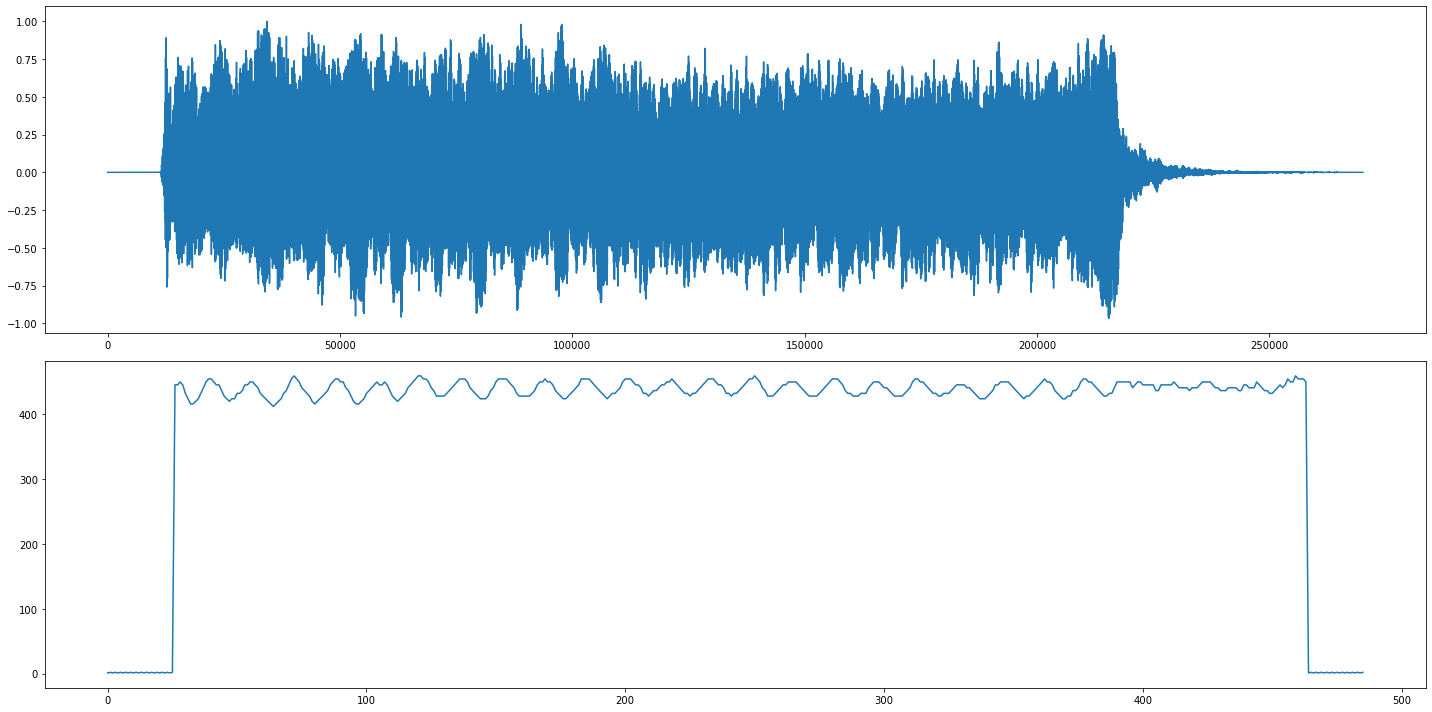

In [6]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(audio)
plt.tight_layout()
plt.subplot(2,1,2)
plt.plot(pitches)
plt.tight_layout()
plt.plot()

# 246.9Hz violin audio

In [7]:
%%time
audio, pitches, vals = fast_pitch_detection("assets/246.9Hz.wav")

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_2148/1984158516.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read(filename)


Wall time: 201 ms


[]

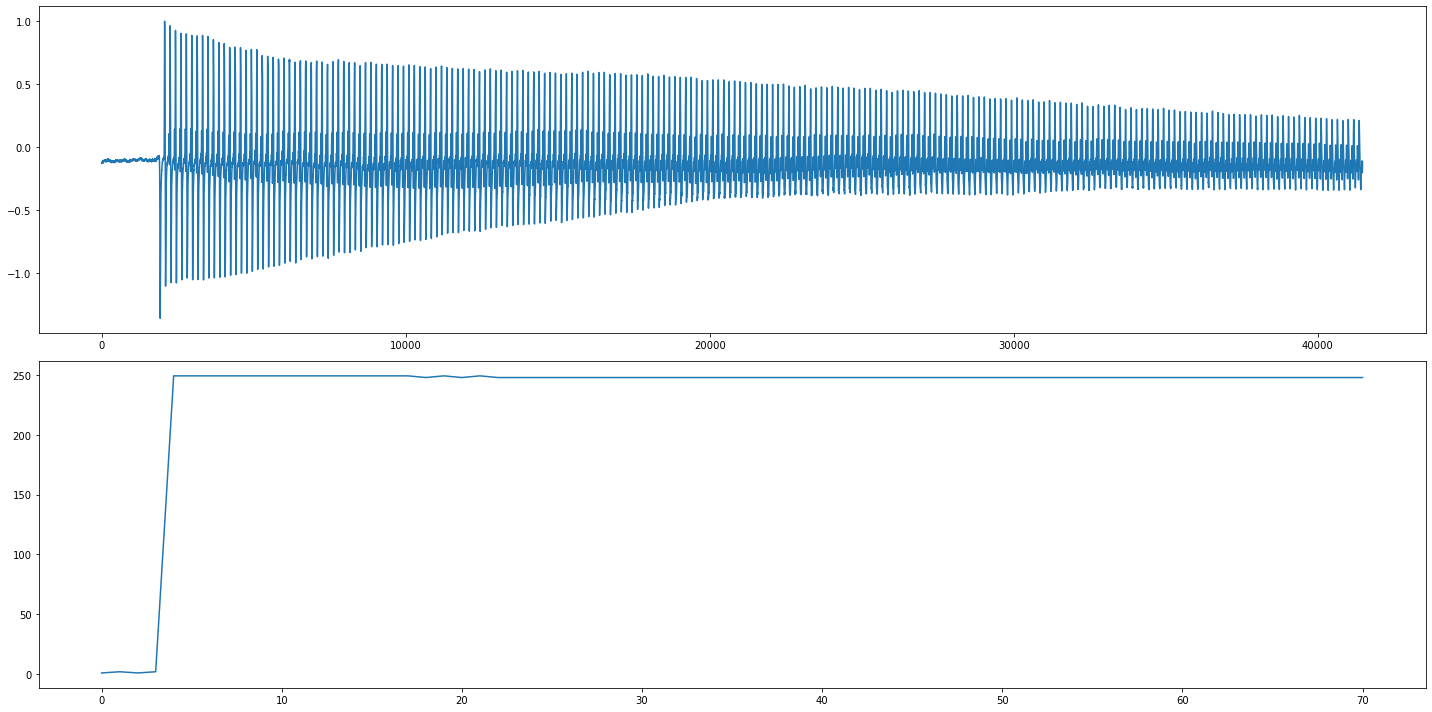

In [8]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(audio)
plt.tight_layout()
plt.subplot(2,1,2)
plt.plot(pitches)
plt.tight_layout()
plt.plot()

# 300Hz audio

In [9]:
%%time
audio, pitches, vals = fast_pitch_detection("assets/300Hz.wav")

Wall time: 1.71 s


[]

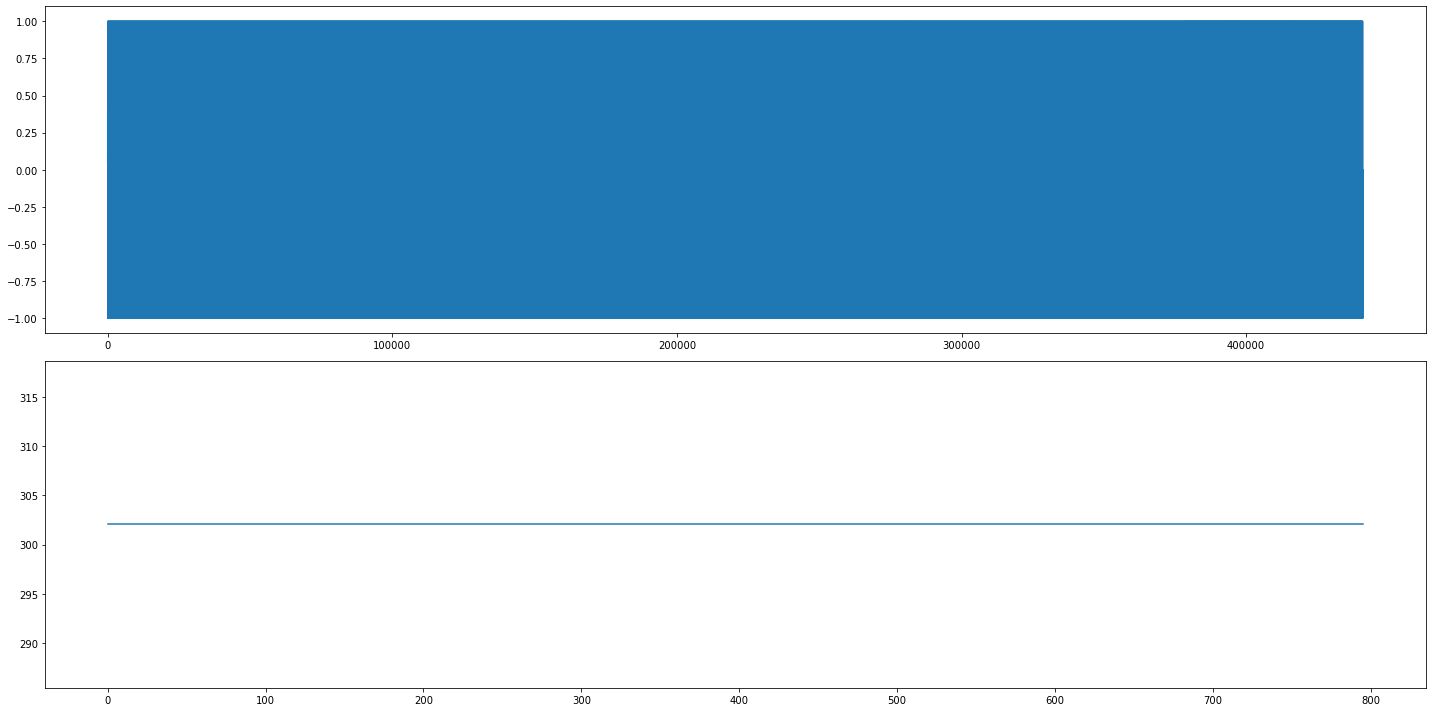

In [10]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(audio)
plt.tight_layout()
plt.subplot(2,1,2)
plt.plot(pitches)
plt.tight_layout()
plt.plot()

# Conversation audio

In [11]:
%%time
audio, pitches, vals = fast_pitch_detection("assets/convesp.wav")

Wall time: 1.62 s


[]

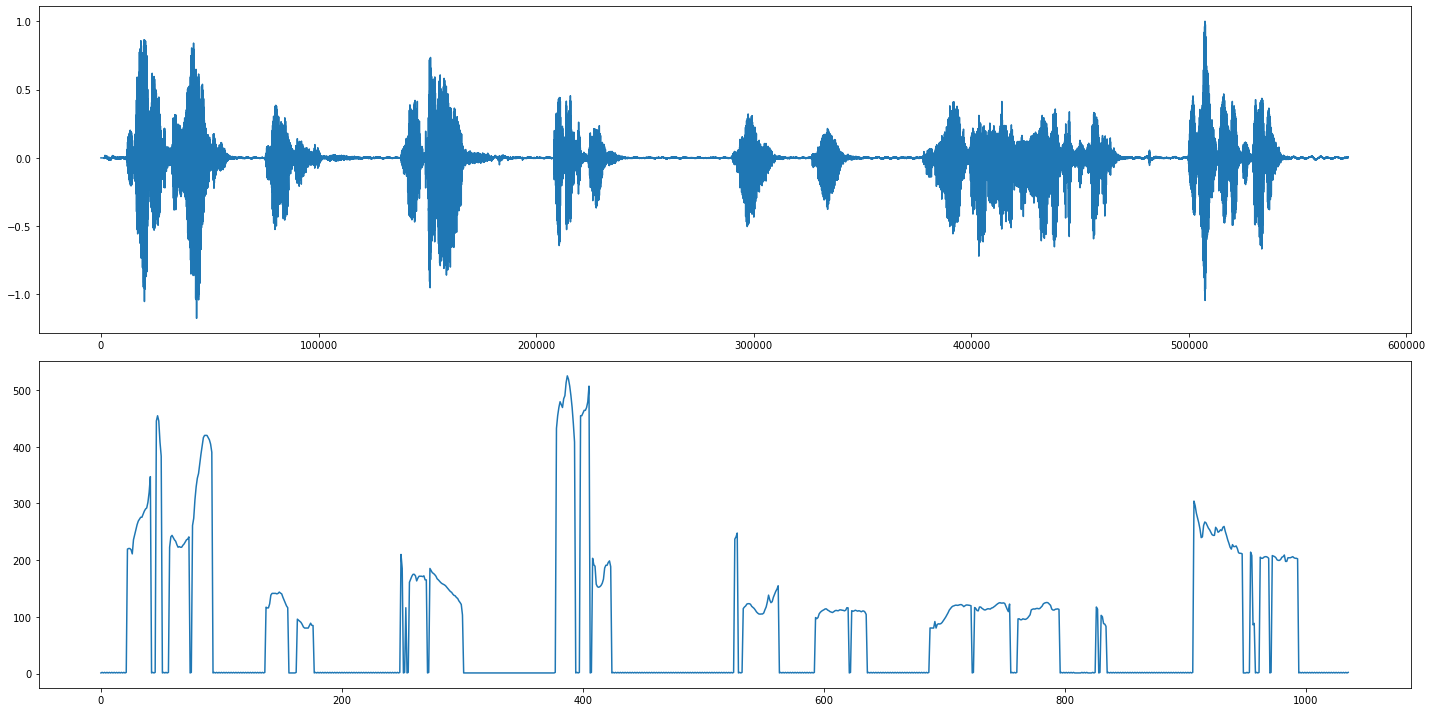

In [12]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(audio)
plt.tight_layout()
plt.subplot(2,1,2)
plt.plot(pitches)
plt.tight_layout()
plt.plot()

# Conversation 2 audio

In [13]:
%%time
audio, pitches, vals = fast_pitch_detection("assets/conversation.wav")

Wall time: 895 ms


[]

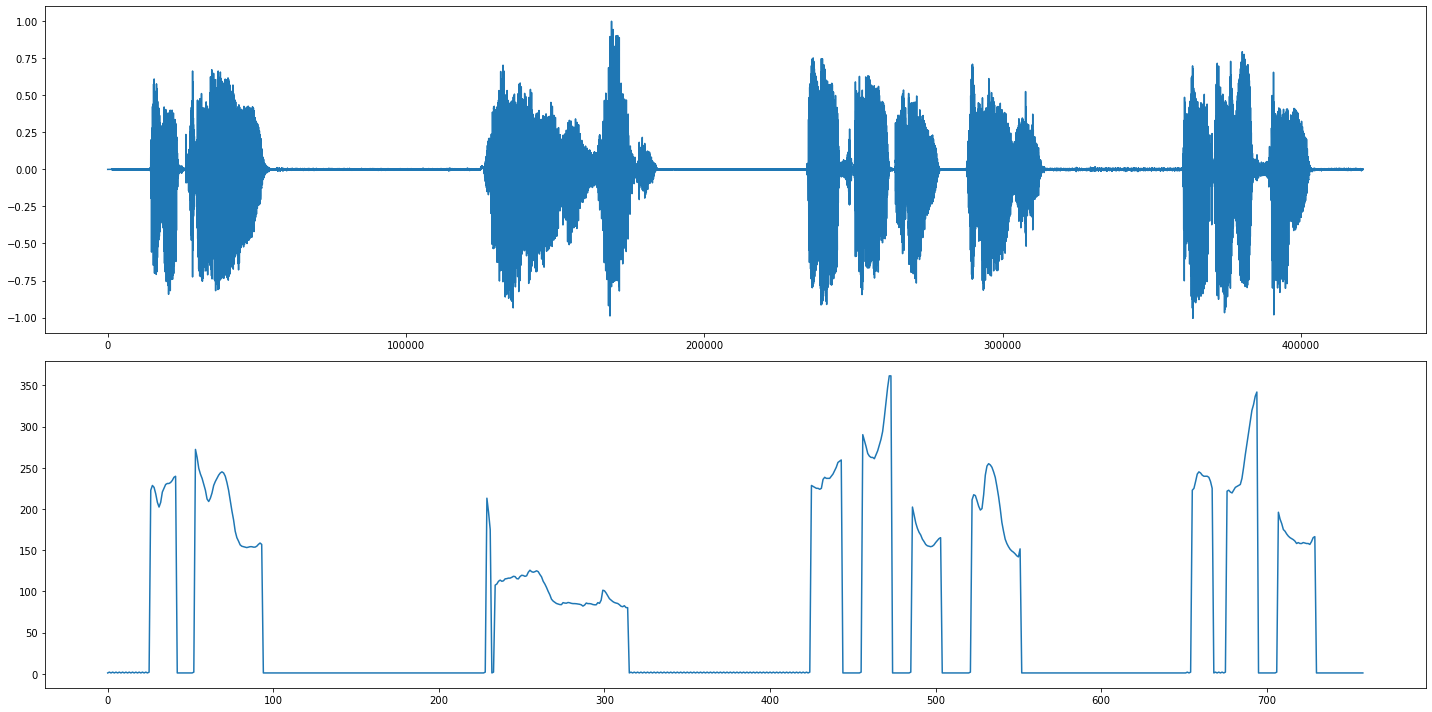

In [14]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(audio)
plt.tight_layout()
plt.subplot(2,1,2)
plt.plot(pitches)
plt.tight_layout()
plt.plot()

# Test voices audio

In [15]:
%%time
audio, pitches, vals = fast_pitch_detection("assets/test_voice.wav")

Wall time: 401 ms


[]

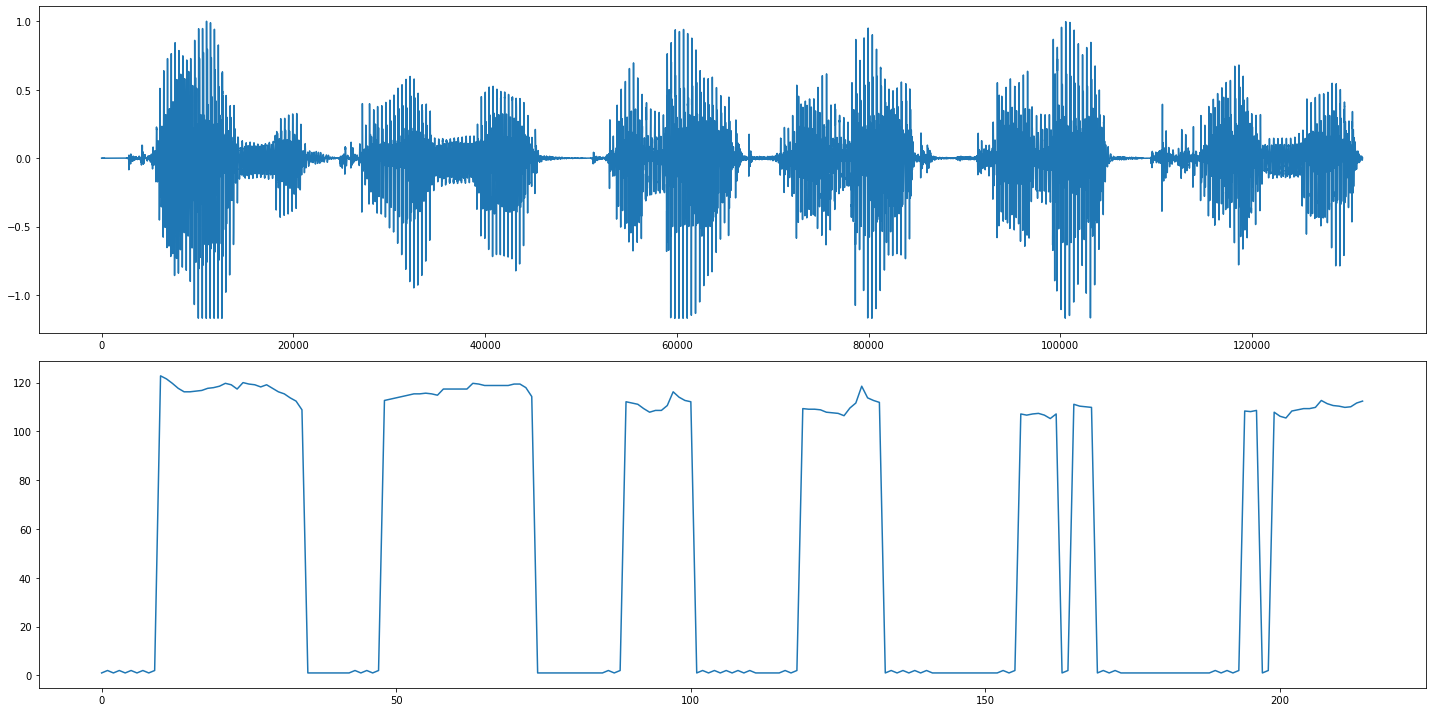

In [16]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(audio)
plt.tight_layout()
plt.subplot(2,1,2)
plt.plot(pitches)
plt.tight_layout()
plt.plot()

# Test long piano audio

In [27]:
%%time
audio, pitches, vals = fast_pitch_detection("assets/assets_saints.wav")

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_2148/1984158516.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read(filename)


Wall time: 15.8 s


[]

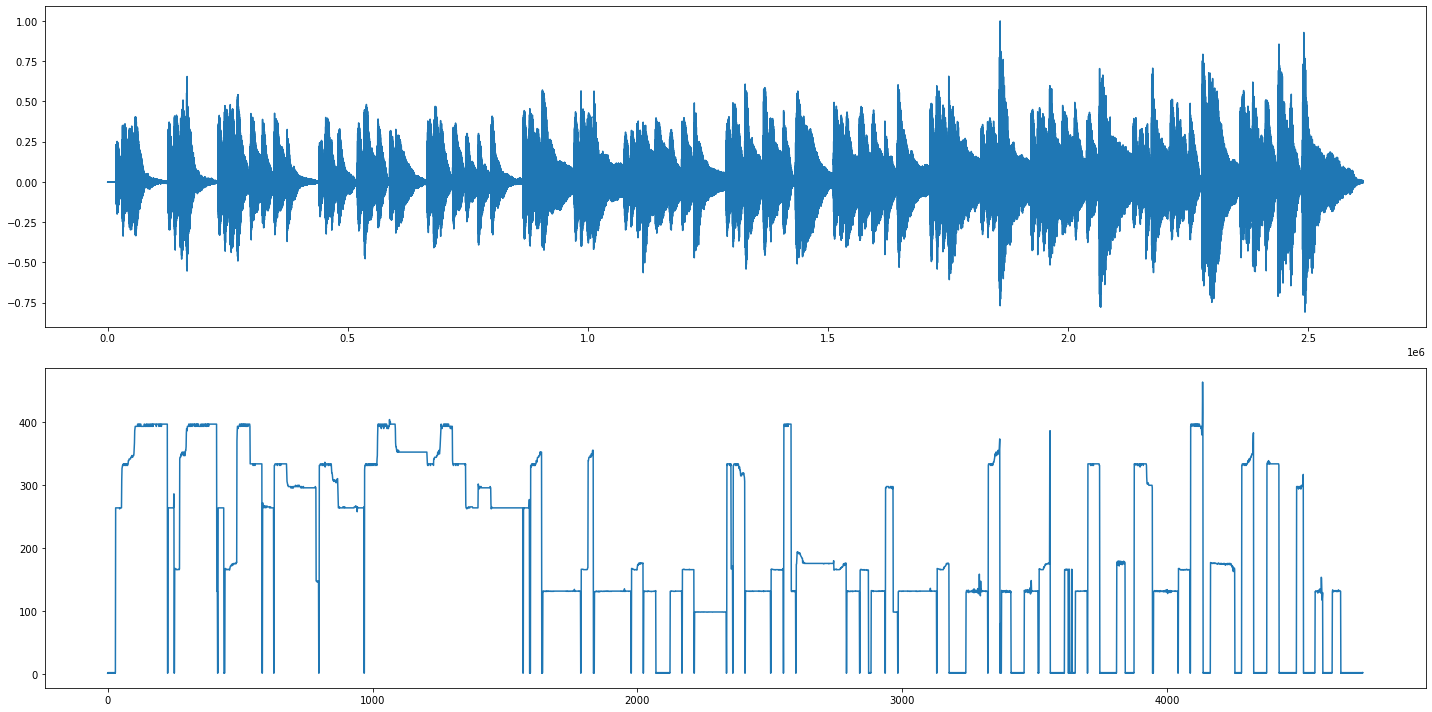

In [28]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(audio)
plt.tight_layout()
plt.subplot(2,1,2)
plt.plot(pitches)
plt.tight_layout()
plt.plot()

# Database 

In [29]:
with open("assets/dataset/ref/ref_F01_si455.f0", "r") as f:
    arr = np.loadtxt(f)

In [30]:
audio, pitches, vals = fast_pitch_detection("assets/dataset/audio/mic_F01_si455.wav", overlap=0.6)

In [31]:
l = min(len(pitches), len(arr[:,0]))

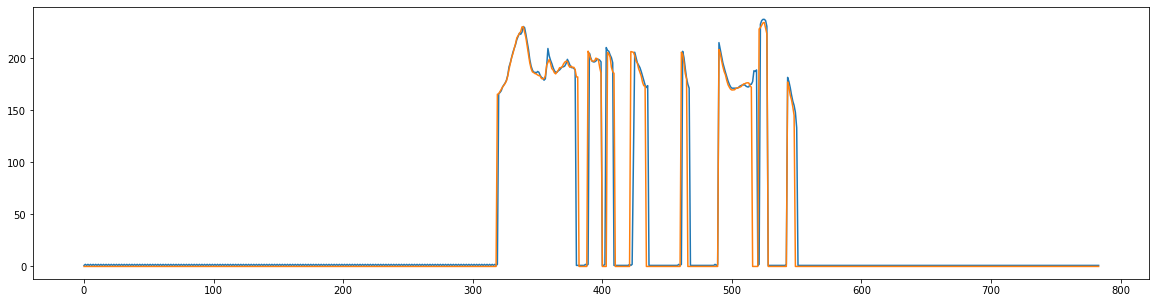

In [32]:
plt.figure(figsize=(20,5))
plt.plot(pitches[:l])
plt.plot(arr[:l,0])

## Dataset

In [22]:
mse = []
percentage = []
for i in range(453, 500):
    with open(f"assets/dataset/ref/ref_F01_si{i}.f0", "r") as f:
        arr = np.array(np.loadtxt(f)[:,0])
    _, pitches, _ = fast_pitch_detection(f"assets/dataset/audio/mic_F01_si{i}.wav", overlap=0.6)
    pitches = np.array(pitches)
    l = min(len(pitches), len(arr))
    sound = np.where((arr[:l] > 0) & (pitches[:l] > 10))
    diff = np.abs(pitches[sound]-arr[sound])
    percentage.append(np.mean(diff/arr[sound]))
    mse.append(np.sum(diff*diff)/l)
    print(f"Audio {i} mse={mse[-1]:.02f} percentage={percentage[-1]:.02}")

Audio 453 mse=59.52 percentage=0.033
Audio 454 mse=3.41 percentage=0.016
Audio 455 mse=15.61 percentage=0.018
Audio 456 mse=49.67 percentage=0.022
Audio 457 mse=3.79 percentage=0.014
Audio 458 mse=2.91 percentage=0.015
Audio 459 mse=84.67 percentage=0.036
Audio 460 mse=3.79 percentage=0.014
Audio 461 mse=150.72 percentage=0.065
Audio 462 mse=4.87 percentage=0.014
Audio 463 mse=3.17 percentage=0.016
Audio 464 mse=31.54 percentage=0.023
Audio 465 mse=2.76 percentage=0.015
Audio 466 mse=107.51 percentage=0.054
Audio 467 mse=24.74 percentage=0.027
Audio 468 mse=24.50 percentage=0.026
Audio 469 mse=11.00 percentage=0.023
Audio 470 mse=2.12 percentage=0.015
Audio 471 mse=415.79 percentage=0.13
Audio 472 mse=49.18 percentage=0.045
Audio 473 mse=33.29 percentage=0.023
Audio 474 mse=8.98 percentage=0.015
Audio 475 mse=3.03 percentage=0.015
Audio 476 mse=225.72 percentage=0.034
Audio 477 mse=4.15 percentage=0.014
Audio 478 mse=2.91 percentage=0.013
Audio 479 mse=165.38 percentage=0.059
Audio 480

In [23]:
np.mean(mse)

66.44762056676574

In [24]:
np.mean(percentage)

0.042129520370135475